### Section 1: Data Preprocessing

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import re
import nltk
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the Dataset
df = pd.read_csv("/content/drive/MyDrive/Stress.csv")
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [ ]:
# Initial Inspection
print("Shape:", df.shape)
print("Null values:\n ", df.isnull().sum())

Shape: (2838, 7)
Null values:
  subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64


In [ ]:
# Drop nulls and keep only valid strings
df = df.dropna(subset=["text"])
df = df[df["text"].apply(lambda x: isinstance(x, str))].reset_index(drop=True)


In [ ]:
# Encode label
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])  # 1 = stressed, 0 = not stressed

In [ ]:
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
from datasets import Dataset
from transformers import RobertaTokenizer

# Create HuggingFace dataset
hf_dataset = Dataset.from_pandas(df[["text", "label"]])

# Tokenize
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = hf_dataset.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/2838 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = tokenized_dataset["train"]
eval_dataset = tokenized_dataset["test"]


In [ ]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import torch

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=15,
    learning_rate=3e-5,
    warmup_steps=500,
    lr_scheduler_type="linear",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_strategy="epoch",
    fp16=True,  # ⚡ Faster on Colab GPU
    report_to="none"
)

# Metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


# Train
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-3bcd2fd0e3ba>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.691900,0.685415,0.524648,0.688222
2,0.594400,0.426571,0.802817,0.834320
3,0.388700,0.389843,0.846831,0.834286
4,0.344500,0.419840,0.815141,0.843982
5,0.240700,0.432452,0.834507,0.855828
6,0.338000,0.432462,0.852113,0.857143
7,0.168500,0.533335,0.852113,0.863636
8,0.131800,0.520735,0.855634,0.863787
9,0.069100,0.906311,0.843310,0.847341
10,0.047100,0.876176,0.834507,0.838488


TrainOutput(global_step=1065, training_loss=0.20569841839338132, metrics={'train_runtime': 405.5476, 'train_samples_per_second': 83.961, 'train_steps_per_second': 2.626, 'total_flos': 2239732858752000.0, 'train_loss': 0.20569841839338132, 'epoch': 15.0})

In [ ]:
# Import DataCollatorWithPadding
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the best checkpoint
checkpoint_path = "/content/results/checkpoint-852"
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path, local_files_only=True)
model.to(device)
model.eval()

# Remove text column
eval_dataset_clean = eval_dataset.remove_columns(["text"])

# Import DataCollatorWithPadding
from transformers import DataCollatorWithPadding

# Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Dataloader
eval_loader = DataLoader(eval_dataset_clean, batch_size=16, collate_fn=data_collator)

# Collect predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in eval_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Using device: cuda


In [ ]:


import torch
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import  DataCollatorWithPadding

              precision    recall  f1-score   support

Not Stressed       0.89      0.79      0.84       270
    Stressed       0.83      0.91      0.87       298

    accuracy                           0.86       568
   macro avg       0.86      0.85      0.85       568
weighted avg       0.86      0.86      0.85       568



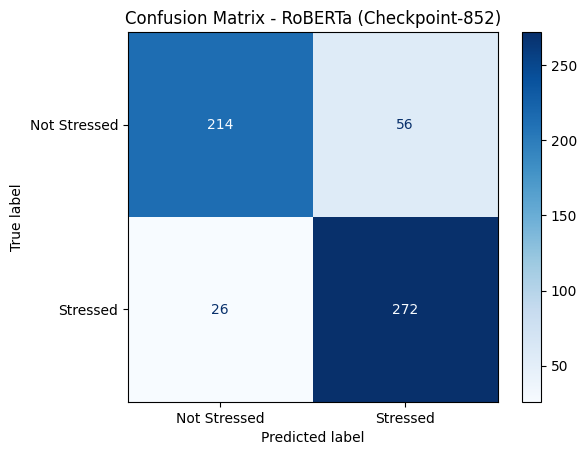

In [ ]:
# Classification report
print(classification_report(all_labels, all_preds, target_names=["Not Stressed", "Stressed"]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Stressed", "Stressed"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - RoBERTa (Checkpoint-852)")
plt.show()


**Evaluation**

In [ ]:
import shutil

checkpoint_dir = "/content/results/checkpoint-852"
output_zip = "/content/results/checkpoint-852.zip"

shutil.make_archive(base_name=output_zip.replace(".zip", ""), format='zip', root_dir=checkpoint_dir)


'/content/results/checkpoint-852.zip'

In [ ]:
!cp -r /content/results/checkpoint-852 /content/drive/MyDrive/
